         system_cost           carbon wave_capacity wave_profit
0  4071060019.858881   6808290.682982  12906.375709         0.0
1  4844292604.430597  10804797.531823   8442.846464   -0.000003
2  5222737847.277706  12190000.000001   4558.582158    0.000002
3  4462092175.427478  11703404.803123  13146.367649    0.000001
4  5129184205.216362  12190000.000002   6460.497148        -0.0
5   5421206974.93739  12190000.000001   1170.450757    0.000002
6  4981361804.843292  12190000.000001  13016.796195        -0.0
7  5496848379.791099  12190000.000001   5104.604118         0.0
8  5564749320.305597  12190000.000002           0.0         0.0
[[4071060019.858881 4844292604.430597 5222737847.277706]
 [4462092175.427478 5129184205.216362 5421206974.93739]
 [4981361804.843292 5496848379.791099 5564749320.305597]]


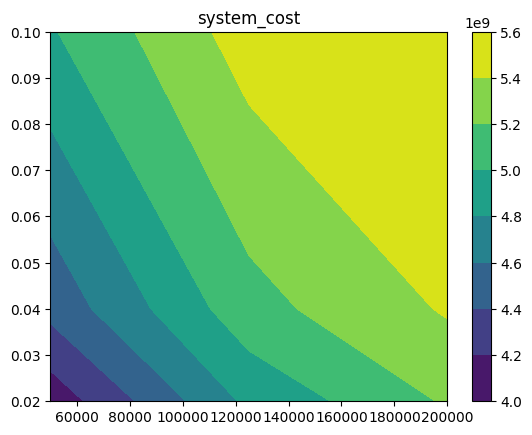

[[6808290.682981964 10804797.531822762 12190000.000001496]
 [11703404.803122664 12190000.000001702 12190000.000001384]
 [12190000.000000764 12190000.000001082 12190000.000001768]]


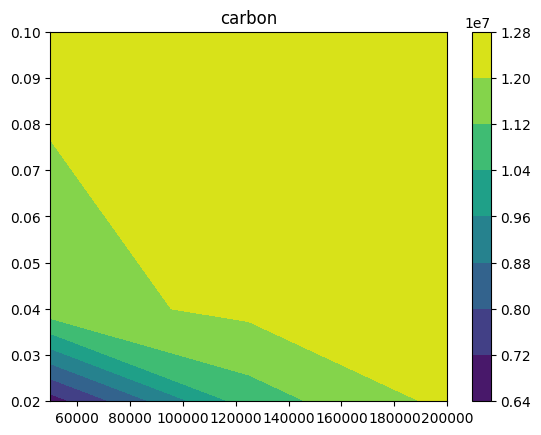

[[12906.375709257862 8442.846464162596 4558.582157581523]
 [13146.367648755691 6460.497147549781 1170.4507567526696]
 [13016.796195128214 5104.604117657895 0.0]]


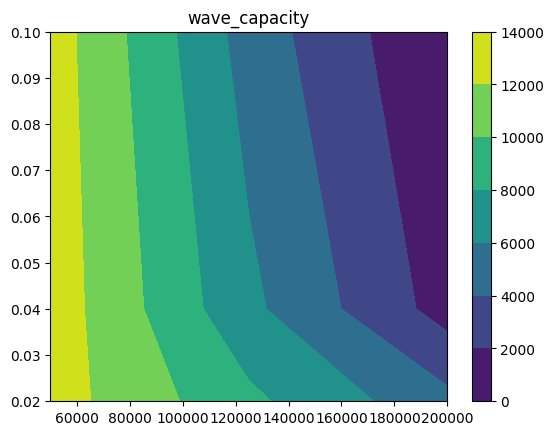

[[4.76837158203125e-07 -3.0994415283203125e-06 1.7881393432617188e-06]
 [1.3113021850585938e-06 -1.1920928955078125e-07 1.728534698486328e-06]
 [-2.384185791015625e-07 3.5762786865234375e-07 0.0]]


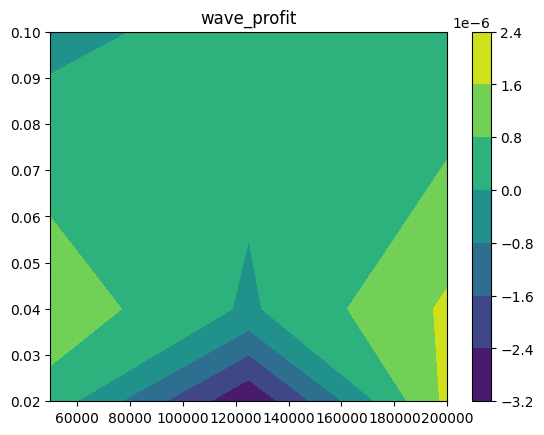

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

inputs = pd.read_csv('replacements.csv')
output_cols = ['system_cost', 'carbon', 'wave_capacity','wave_profit']
outputs = pd.DataFrame(index=inputs.index, columns=output_cols)

for case in np.arange(1,len(inputs)+1):
    idx = case-1
    result_folder = os.path.join('Cases','case_'+str(case),'Results')
    cost_file     = os.path.join(result_folder,'costs.csv')
    carbon_file   = os.path.join(result_folder,'emissions.csv')
    capacity_file = os.path.join(result_folder,'capacity.csv')
    revenue_file  = os.path.join(result_folder,'NetRevenue.csv')

    system_cost_df   = pd.read_csv(cost_file,     index_col='Costs')
    carbon_df        = pd.read_csv(carbon_file,   index_col='Zone', nrows=3)
    wave_capacity_df = pd.read_csv(capacity_file, index_col='Resource',usecols=['Resource','EndCap'])
    wave_profit_df   = pd.read_csv(revenue_file,  index_col='Resource',usecols=['Resource','Profit'])
    
    system_cost = system_cost_df['Total'].loc['cTotal']
    carbon = carbon_df['Total'].loc['AnnualSum']
    wave_profit = wave_profit_df['Profit'].loc['NENGREST_wave']
    wave_capacity = wave_capacity_df['EndCap'].loc['NENGREST_wave']
    outputs.loc[idx] = [system_cost,carbon,wave_capacity,wave_profit]

print(outputs)

square_size = np.sqrt(inputs.waveInvCost.size).astype(int)
square_tuple = (square_size,square_size)

wec_cost  = np.reshape(inputs.waveInvCost.values, square_tuple)
power_lim = np.reshape(inputs.Notes.values,       square_tuple)

for output in output_cols:
    output_reshaped = np.reshape(outputs[output].values, square_tuple)
    print(output_reshaped)
    plt.contourf(wec_cost,power_lim,output_reshaped.astype(float))
    plt.title(output)
    plt.colorbar()
    plt.show()